All libraries imported successfully
Dataset Shape: (110, 18)

Columns: ['Age', 'Gender', 'StudyHours', 'SleepHours', 'ReviewCenter', 'MockExamScore', 'GPA', 'Scholarship', 'InternshipGrade', 'IncomeLevel', 'EmploymentStatus', 'Confidence', 'TestAnxiety', 'EnglishProficiency', 'MotivationScore', 'SocialSupport', 'ExamResultPercent', 'Passed']
DATA EXPLORATION

Missing Values:
MockExamScore      26
InternshipGrade    30
dtype: int64

Target Distribution:
count    110.000000
mean      76.718182
std        2.657866
min       63.800000
25%       75.525000
50%       76.650000
75%       78.500000
max       81.800000
Name: ExamResultPercent, dtype: float64


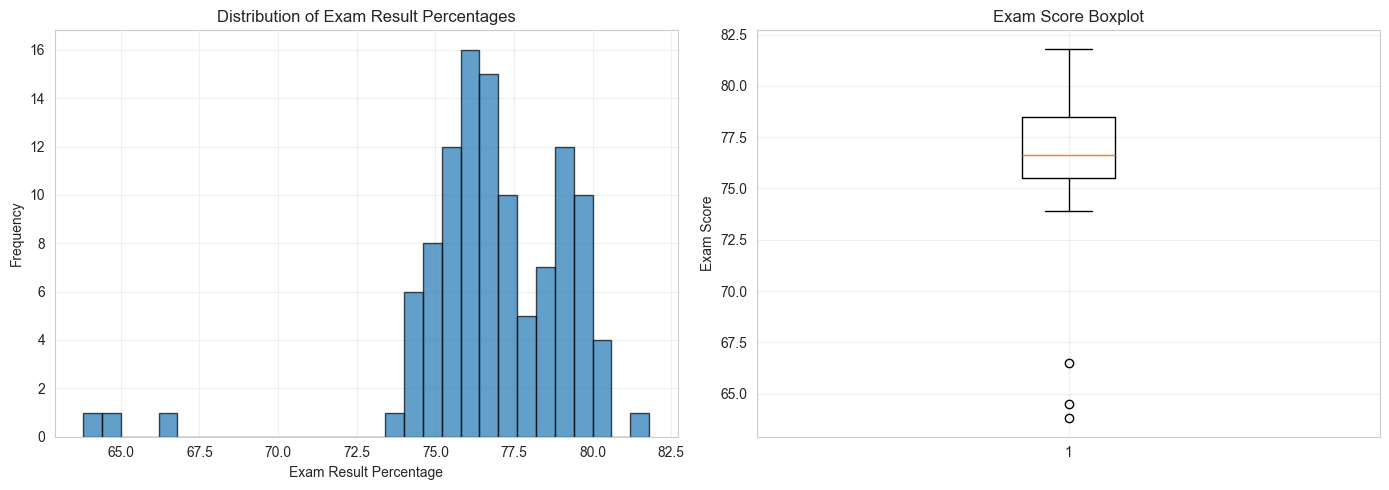

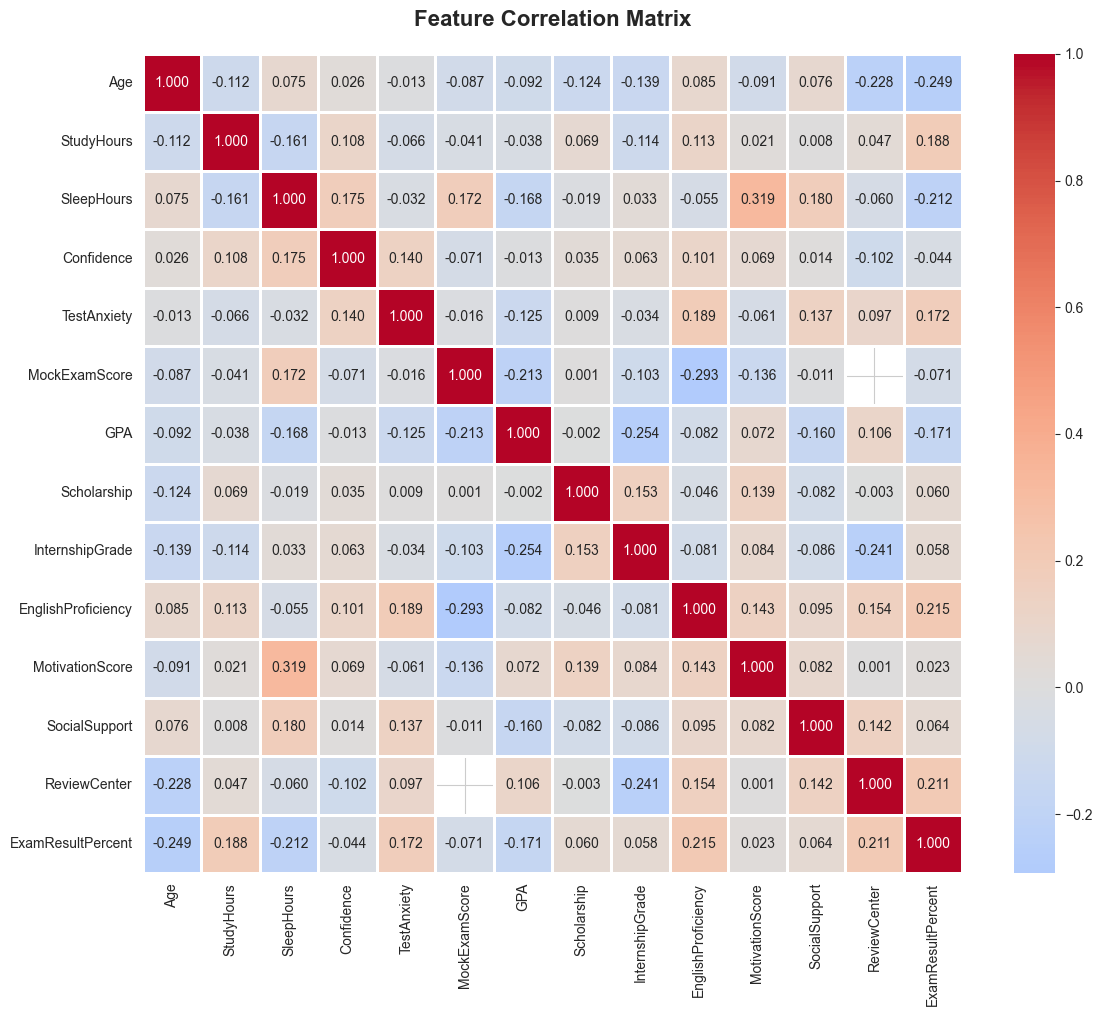


Top Features Correlated with Exam Result Percentage:
   Age: 0.2490
   EnglishProficiency: 0.2152
   SleepHours: 0.2123
   ReviewCenter: 0.2109
   StudyHours: 0.1878
   TestAnxiety: 0.1721
   GPA: 0.1708
   MockExamScore: 0.0712
   SocialSupport: 0.0636
   Scholarship: 0.0597
DATA PREPROCESSING FOR MODEL TRAINING

Train-Test Split Complete:
   Training samples: 88
   Test samples: 22
   Target range (train): [64.50, 81.80]
   Target range (test): [63.80, 80.20]

[STEP 1] Handling Missing Values...
Missing values in training data:
MockExamScore      22
InternshipGrade    21
dtype: int64

Imputing grade-based columns with IterativeImputer...

No missing values in score columns
All missing values handled successfully

[STEP 2] Encoding Categorical Variables...
   Encoded: Gender (2 classes)
   Encoded: IncomeLevel (3 classes)
   Encoded: EmploymentStatus (3 classes)
Encoding complete

[STEP 3] Scaling Features...

Scaling complete:
   Training data shape: (88, 16)
   Test data shape: (22

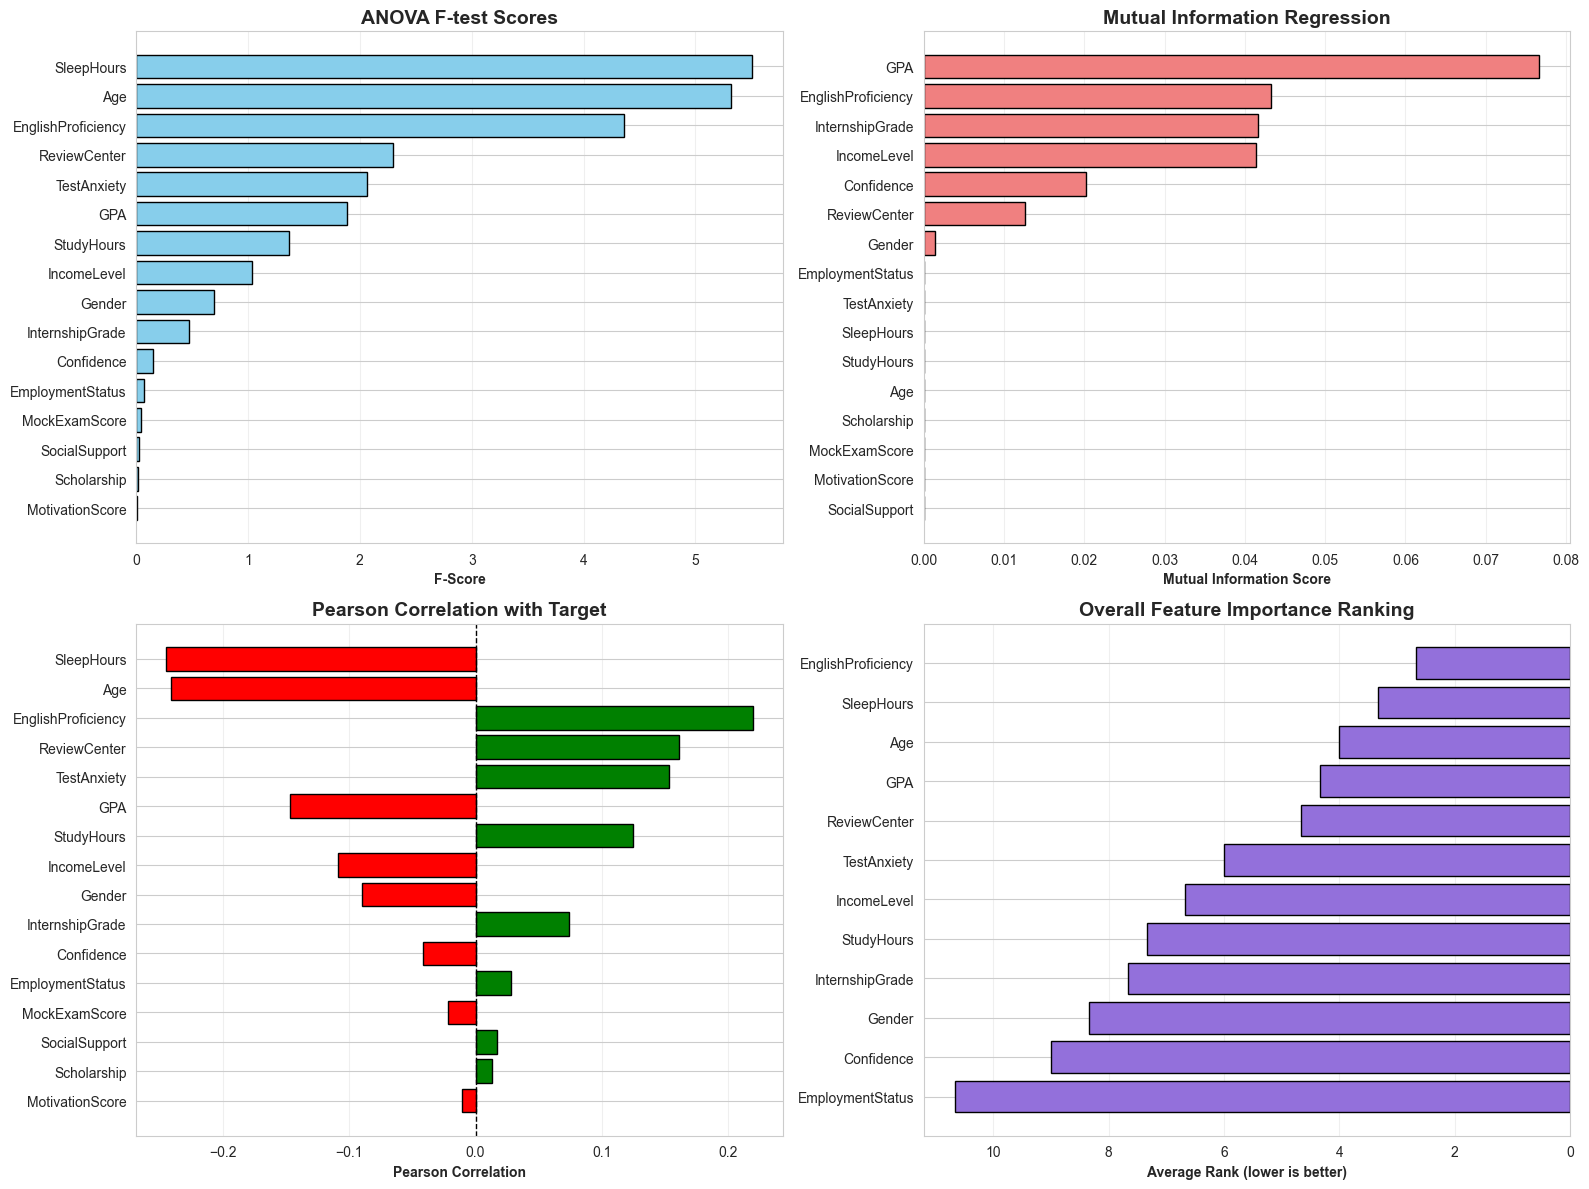


SAVING PREPROCESSED DATA

Final Data Validation:
   X_train shape: (88, 16)
   X_test shape: (22, 16)
   y_train shape: (88,)
   y_test shape: (22,)
   X_train NaN count: 0
   X_test NaN count: 0
   X_train Inf count: 0
   X_test Inf count: 0
   Numpy arrays saved
   Scaler saved
   Label encoders saved
   Iterative imputer saved
   Median imputer saved
   Feature names saved
   Imputation config saved
   Preprocessing config saved
   Feature importance analysis saved

Verifying saved files...
   All pickle files verified successfully

All files saved to ../regression_processed_data_dataset/
Files created:
   - X_train.npy, X_test.npy, y_train.npy, y_test.npy
   - scaler.pkl, label_encoders.pkl
   - iterative_imputer.pkl, median_imputer.pkl
   - feature_names.json
   - preprocessing_config.json
   - imputation_config.json
   - feature_importance_analysis.json
   - README.md


In [4]:
import pandas as pd
import numpy as np
import json
import os
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from scipy.stats import pearsonr
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("All libraries imported successfully")

# Load data
df = pd.read_csv('../data/social_work_exam_raw.csv')
print(f"Dataset Shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
df.head()

print("=" * 60)
print("DATA EXPLORATION")
print("=" * 60)

print("\nMissing Values:")
missing = df.isnull().sum()
if missing.sum() == 0:
    print("   No missing values!")
else:
    print(missing[missing > 0])

print(f"\nTarget Distribution:")
print(df['ExamResultPercent'].describe())

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['ExamResultPercent'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Exam Result Percentage')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Exam Result Percentages')
axes[0].grid(alpha=0.3)

axes[1].boxplot(df['ExamResultPercent'])
axes[1].set_ylabel('Exam Score')
axes[1].set_title('Exam Score Boxplot')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Define column types
categorical_columns = ['Gender', 'IncomeLevel', 'EmploymentStatus']
numerical_columns = ['Age', 'StudyHours', 'SleepHours', 'Confidence', 'TestAnxiety',
                    'MockExamScore', 'GPA', 'Scholarship', 'InternshipGrade', 
                    'EnglishProficiency', 'MotivationScore', 'SocialSupport']
binary_columns = ['ReviewCenter']

grade_columns = ['GPA', 'InternshipGrade', 'MockExamScore']
score_columns = [col for col in numerical_columns if col not in grade_columns]

# Correlation analysis
numerical_cols = numerical_columns + binary_columns
correlation_matrix = df[numerical_cols + ['ExamResultPercent']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

target_corr = correlation_matrix['ExamResultPercent'].drop('ExamResultPercent').abs().sort_values(ascending=False)
print("\nTop Features Correlated with Exam Result Percentage:")
for feature, corr in target_corr.head(10).items():
    print(f"   {feature}: {corr:.4f}")

print("=" * 60)
print("DATA PREPROCESSING FOR MODEL TRAINING")
print("=" * 60)

# Prepare features and target
X_full = df[categorical_columns + numerical_columns + binary_columns].copy()
y_full = df['ExamResultPercent'].values

# CRITICAL FIX: Split data BEFORE any preprocessing to prevent data leakage
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, shuffle=True
)

print(f"\nTrain-Test Split Complete:")
print(f"   Training samples: {len(X_train_raw)}")
print(f"   Test samples: {len(X_test_raw)}")
print(f"   Target range (train): [{y_train.min():.2f}, {y_train.max():.2f}]")
print(f"   Target range (test): [{y_test.min():.2f}, {y_test.max():.2f}]")

# Step 1: Handle missing values - FIT ON TRAIN ONLY
print("\n[STEP 1] Handling Missing Values...")
print(f"Missing values in training data:\n{X_train_raw.isnull().sum()[X_train_raw.isnull().sum() > 0]}")

# Initialize imputers
iterative_imputer = IterativeImputer(random_state=42, max_iter=10, verbose=0)
median_imputer = SimpleImputer(strategy='median')

# Create copies for imputation
X_train_imputed = X_train_raw.copy()
X_test_imputed = X_test_raw.copy()

# FIT imputers on training data only, then transform both
if X_train_raw[grade_columns].isnull().any().any():
    print("\nImputing grade-based columns with IterativeImputer...")
    X_train_imputed[grade_columns] = iterative_imputer.fit_transform(X_train_raw[grade_columns])
    X_test_imputed[grade_columns] = iterative_imputer.transform(X_test_raw[grade_columns])
else:
    print("\nNo missing values in grade columns")

if X_train_raw[score_columns].isnull().any().any():
    print("\nImputing score-based columns with median...")
    X_train_imputed[score_columns] = median_imputer.fit_transform(X_train_raw[score_columns])
    X_test_imputed[score_columns] = median_imputer.transform(X_test_raw[score_columns])
else:
    print("\nNo missing values in score columns")

# Verify no missing values remain
assert not X_train_imputed.isnull().any().any(), "ERROR: Training data still has missing values"
assert not X_test_imputed.isnull().any().any(), "ERROR: Test data still has missing values"
print("All missing values handled successfully")

# Step 2: Encode categorical variables - FIT ON TRAIN ONLY
print("\n[STEP 2] Encoding Categorical Variables...")
label_encoders = {}
X_train_encoded = X_train_imputed.copy()
X_test_encoded = X_test_imputed.copy()

for col in categorical_columns:
    le = LabelEncoder()
    # Fit on training data
    X_train_encoded[col] = le.fit_transform(X_train_imputed[col].astype(str))
    
    # Handle potential unseen categories in test data
    def safe_transform(x):
        try:
            return le.transform([str(x)])[0]
        except ValueError:
            # If category not seen in training, use most frequent class
            return le.transform([le.classes_[0]])[0]
    
    X_test_encoded[col] = X_test_imputed[col].apply(safe_transform)
    label_encoders[col] = le
    print(f"   Encoded: {col} ({len(le.classes_)} classes)")

# Verify no NaN after encoding
assert not X_train_encoded.isnull().any().any(), "ERROR: NaN in training data after encoding"
assert not X_test_encoded.isnull().any().any(), "ERROR: NaN in test data after encoding"
print("Encoding complete")

# Step 3: Scale features - FIT ON TRAIN ONLY
print("\n[STEP 3] Scaling Features...")
scaler = StandardScaler()

# Fit on training data and transform both
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Final validation
assert not np.isnan(X_train_scaled).any(), "ERROR: NaN in scaled training data"
assert not np.isnan(X_test_scaled).any(), "ERROR: NaN in scaled test data"
assert not np.isinf(X_train_scaled).any(), "ERROR: Inf in scaled training data"
assert not np.isinf(X_test_scaled).any(), "ERROR: Inf in scaled test data"

print(f"\nScaling complete:")
print(f"   Training data shape: {X_train_scaled.shape}")
print(f"   Test data shape: {X_test_scaled.shape}")
print(f"   Training mean: {X_train_scaled.mean():.6f} (should be ~0)")
print(f"   Training std: {X_train_scaled.std():.6f} (should be ~1)")

# Feature importance analysis on preprocessed training data
print("\n" + "=" * 60)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

# ANOVA F-test
print("\n[METHOD 1] ANOVA F-test (f_regression)")
selector_f = SelectKBest(score_func=f_regression, k='all')
selector_f.fit(X_train_scaled, y_train)

feature_names = categorical_columns + numerical_columns + binary_columns

f_scores_df = pd.DataFrame({
    'Feature': feature_names,
    'F_Score': selector_f.scores_,
    'P_Value': selector_f.pvalues_
}).sort_values('F_Score', ascending=False)

print("\nANOVA F-test Results:")
for idx, row in f_scores_df.iterrows():
    sig = "***" if row['P_Value'] < 0.001 else "**" if row['P_Value'] < 0.01 else "*" if row['P_Value'] < 0.05 else ""
    print(f"   {row['Feature']:20s}: F={row['F_Score']:8.2f}, p={row['P_Value']:.4f} {sig}")

# Mutual Information
print("\n[METHOD 2] Mutual Information Regression")
mi_scores = mutual_info_regression(X_train_scaled, y_train, random_state=42, n_neighbors=5)
mi_scores_df = pd.DataFrame({
    'Feature': feature_names,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending=False)

print("\nMutual Information Scores:")
for idx, row in mi_scores_df.iterrows():
    print(f"   {row['Feature']:20s}: {row['MI_Score']:.6f}")

# Pearson Correlation
print("\n[METHOD 3] Pearson Correlation Analysis")
pearson_results = []
for i, col_name in enumerate(feature_names):
    corr_coef, p_value = pearsonr(X_train_scaled[:, i], y_train)
    pearson_results.append({
        'Feature': col_name,
        'Correlation': corr_coef,
        'Abs_Correlation': abs(corr_coef),
        'P_Value': p_value,
        'Significant': p_value < 0.05
    })

pearson_df = pd.DataFrame(pearson_results).sort_values('Abs_Correlation', ascending=False)

print("\nPearson Correlation Results:")
for idx, row in pearson_df.iterrows():
    sig = "***" if row['P_Value'] < 0.001 else "**" if row['P_Value'] < 0.01 else "*" if row['P_Value'] < 0.05 else ""
    print(f"   {row['Feature']:20s}: r={row['Correlation']:7.4f}, p={row['P_Value']:.4f} {sig}")

# Combined ranking
print("\n" + "=" * 60)
print("COMBINED FEATURE IMPORTANCE RANKING")
print("=" * 60)

combined = f_scores_df.merge(mi_scores_df, on='Feature')
combined = combined.merge(pearson_df[['Feature', 'Correlation', 'Abs_Correlation']], on='Feature')

combined['F_Rank'] = combined['F_Score'].rank(ascending=False, method='min')
combined['MI_Rank'] = combined['MI_Score'].rank(ascending=False, method='min')
combined['Corr_Rank'] = combined['Abs_Correlation'].rank(ascending=False, method='min')
combined['Avg_Rank'] = combined[['F_Rank', 'MI_Rank', 'Corr_Rank']].mean(axis=1)

combined = combined.sort_values('Avg_Rank')

print("\nTop Features (by average rank):")
print(f"\n{'Rank':<6}{'Feature':<20}{'F-Score':<12}{'MI-Score':<12}{'Pearson r':<12}{'Avg Rank':<10}")
print("-" * 72)
for i, (idx, row) in enumerate(combined.head(12).iterrows(), 1):
    print(f"{i:<6}{row['Feature']:<20}{row['F_Score']:<12.2f}{row['MI_Score']:<12.6f}{row['Correlation']:<12.4f}{row['Avg_Rank']:<10.2f}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].barh(f_scores_df['Feature'], f_scores_df['F_Score'], color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('F-Score', fontweight='bold')
axes[0, 0].set_title('ANOVA F-test Scores', fontweight='bold', fontsize=14)
axes[0, 0].invert_yaxis()
axes[0, 0].grid(axis='x', alpha=0.3)

axes[0, 1].barh(mi_scores_df['Feature'], mi_scores_df['MI_Score'], color='lightcoral', edgecolor='black')
axes[0, 1].set_xlabel('Mutual Information Score', fontweight='bold')
axes[0, 1].set_title('Mutual Information Regression', fontweight='bold', fontsize=14)
axes[0, 1].invert_yaxis()
axes[0, 1].grid(axis='x', alpha=0.3)

colors = ['green' if x > 0 else 'red' for x in pearson_df['Correlation']]
axes[1, 0].barh(pearson_df['Feature'], pearson_df['Correlation'], color=colors, edgecolor='black')
axes[1, 0].set_xlabel('Pearson Correlation', fontweight='bold')
axes[1, 0].set_title('Pearson Correlation with Target', fontweight='bold', fontsize=14)
axes[1, 0].invert_yaxis()
axes[1, 0].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[1, 0].grid(axis='x', alpha=0.3)

axes[1, 1].barh(combined.head(12)['Feature'], combined.head(12)['Avg_Rank'], color='mediumpurple', edgecolor='black')
axes[1, 1].set_xlabel('Average Rank (lower is better)', fontweight='bold')
axes[1, 1].set_title('Overall Feature Importance Ranking', fontweight='bold', fontsize=14)
axes[1, 1].invert_yaxis()
axes[1, 1].invert_xaxis()
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Save preprocessed data and artifacts
print("\n" + "=" * 60)
print("SAVING PREPROCESSED DATA")
print("=" * 60)

output_dir = '../regression_processed_data_dataset'
os.makedirs(output_dir, exist_ok=True)

# Final verification before saving
print("\nFinal Data Validation:")
print(f"   X_train shape: {X_train_scaled.shape}")
print(f"   X_test shape: {X_test_scaled.shape}")
print(f"   y_train shape: {y_train.shape}")
print(f"   y_test shape: {y_test.shape}")
print(f"   X_train NaN count: {np.isnan(X_train_scaled).sum()}")
print(f"   X_test NaN count: {np.isnan(X_test_scaled).sum()}")
print(f"   X_train Inf count: {np.isinf(X_train_scaled).sum()}")
print(f"   X_test Inf count: {np.isinf(X_test_scaled).sum()}")

# Save numpy arrays
np.save(f'{output_dir}/X_train.npy', X_train_scaled)
np.save(f'{output_dir}/X_test.npy', X_test_scaled)
np.save(f'{output_dir}/y_train.npy', y_train)
np.save(f'{output_dir}/y_test.npy', y_test)
print("   Numpy arrays saved")

# Save preprocessing objects with proper error handling
try:
    # Save scaler
    with open(f'{output_dir}/scaler.pkl', 'wb') as f:
        joblib.dump(scaler, f, compress=3)
    print("   Scaler saved")
    
    # Save label encoders dictionary
    with open(f'{output_dir}/label_encoders.pkl', 'wb') as f:
        joblib.dump(label_encoders, f, compress=3)
    print("   Label encoders saved")
    
    # Save iterative imputer
    with open(f'{output_dir}/iterative_imputer.pkl', 'wb') as f:
        joblib.dump(iterative_imputer, f, compress=3)
    print("   Iterative imputer saved")
    
    # Save median imputer
    with open(f'{output_dir}/median_imputer.pkl', 'wb') as f:
        joblib.dump(median_imputer, f, compress=3)
    print("   Median imputer saved")
    
except Exception as e:
    print(f"   ERROR saving preprocessing objects: {e}")
    raise

# Save feature names
with open(f'{output_dir}/feature_names.json', 'w') as f:
    json.dump(feature_names, f, indent=2)
print("   Feature names saved")

# Save imputation configuration
imputation_config = {
    'grade_columns': grade_columns,
    'score_columns': score_columns,
    'categorical_columns': categorical_columns,
    'numerical_columns': numerical_columns,
    'binary_columns': binary_columns,
    'grade_imputer_type': 'IterativeImputer',
    'score_imputer_type': 'SimpleImputer_median',
    'grade_imputer_params': {
        'random_state': 42,
        'max_iter': 10,
        'verbose': 0
    },
    'score_imputer_params': {
        'strategy': 'median'
    }
}

with open(f'{output_dir}/imputation_config.json', 'w') as f:
    json.dump(imputation_config, f, indent=2)
print("   Imputation config saved")

# Save preprocessing configuration
preprocessing_config = {
    'categorical_columns': categorical_columns,
    'numerical_columns': numerical_columns,
    'binary_columns': binary_columns,
    'grade_columns': grade_columns,
    'score_columns': score_columns,
    'grade_imputer': 'IterativeImputer',
    'score_imputer': 'SimpleImputer_median',
    'scaler': 'StandardScaler',
    'test_size': 0.2,
    'random_state': 42,
    'n_features': len(feature_names),
    'n_train_samples': len(X_train_scaled),
    'n_test_samples': len(X_test_scaled)
}

with open(f'{output_dir}/preprocessing_config.json', 'w') as f:
    json.dump(preprocessing_config, f, indent=2)
print("   Preprocessing config saved")

# Save feature importance results
feature_importance_results = {
    'anova_f_test': f_scores_df.to_dict('records'),
    'mutual_information': mi_scores_df.to_dict('records'),
    'pearson_correlation': pearson_df.to_dict('records'),
    'combined_ranking': combined.to_dict('records')
}

with open(f'{output_dir}/feature_importance_analysis.json', 'w') as f:
    json.dump(feature_importance_results, f, indent=2)
print("   Feature importance analysis saved")

# Verify saved files by loading them
print("\nVerifying saved files...")
try:
    test_scaler = joblib.load(f'{output_dir}/scaler.pkl')
    test_encoders = joblib.load(f'{output_dir}/label_encoders.pkl')
    test_iter_imp = joblib.load(f'{output_dir}/iterative_imputer.pkl')
    test_med_imp = joblib.load(f'{output_dir}/median_imputer.pkl')
    print("   All pickle files verified successfully")
except Exception as e:
    print(f"   ERROR verifying files: {e}")
    raise

# Create a README for the processed data
readme_content = f"""# Preprocessed Data for Regression Models

## Data Split
- Training samples: {len(X_train_scaled)}
- Test samples: {len(X_test_scaled)}
- Test size: 20%
- Random state: 42

## Features
- Total features: {len(feature_names)}
- Categorical: {len(categorical_columns)}
- Numerical: {len(numerical_columns)}
- Binary: {len(binary_columns)}

## Preprocessing Steps
1. Train-test split (prevents data leakage)
2. Missing value imputation (fit on train only)
   - Grade columns: IterativeImputer
   - Score columns: Median imputation
3. Categorical encoding (fit on train only)
   - LabelEncoder for categorical variables
4. Feature scaling (fit on train only)
   - StandardScaler (mean=0, std=1)

## Files
- X_train.npy: Training features (scaled)
- X_test.npy: Test features (scaled)
- y_train.npy: Training target
- y_test.npy: Test target
- scaler.pkl: Fitted StandardScaler
- label_encoders.pkl: Dictionary of fitted LabelEncoders
- iterative_imputer.pkl: Fitted IterativeImputer
- median_imputer.pkl: Fitted SimpleImputer
- feature_names.json: List of feature names
- preprocessing_config.json: Complete preprocessing configuration
- imputation_config.json: Imputation strategy configuration
- feature_importance_analysis.json: Feature importance results

## Data Validation
All data has been validated for:
- No missing values (NaN)
- No infinite values (Inf)
- Consistent shapes
- Proper scaling (mean ~0, std ~1 for training data)

Generated: {pd.Timestamp.now()}
"""

with open(f'{output_dir}/README.md', 'w') as f:
    f.write(readme_content)

print(f"\nAll files saved to {output_dir}/")
print("Files created:")
print("   - X_train.npy, X_test.npy, y_train.npy, y_test.npy")
print("   - scaler.pkl, label_encoders.pkl")
print("   - iterative_imputer.pkl, median_imputer.pkl")
print("   - feature_names.json")
print("   - preprocessing_config.json")
print("   - imputation_config.json")
print("   - feature_importance_analysis.json")
print("   - README.md")